# Анализ продуктовых метрик и удержания маркетплейса:

В ходе проекта необходимо:    
1: Оценить месячный retention в оформление заказа с помощью когортного анализа.  
2: Определить, существует ли product/market fit у этого маркетплейса.  
3: Определить 5 основных метрик, на которых стоит сконцентрироваться, чтобы максимизировать прибыль компании.  
4: Выбрать одну из 3 основных гипотез с помощью фреймворка ICE.  
5: Сформулировать нужные метрики, на которые выбранная гипотеза должна повлиять.  
6: Выводы о проделанной работе.  

In [2]:
import numpy as np
import pandas as pd
import yadisk
from io import BytesIO


import seaborn as sns
import plotly.io as pio
pio.renderers.default = 'iframe_connected' 
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from operator import attrgetter

sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")

In [3]:
# olist_customers — таблица с уникальными идентификаторами пользователей
# customer_id — позаказный идентификатор пользователя
# customer_unique_id — уникальный идентификатор пользователя (аналог номера паспорта)
# customer_zip_code_prefix — почтовый индекс пользователя
# customer_city — город доставки пользователя
# customer_state — штат доставки пользователя

In [4]:
y = yadisk.YaDisk()

public_url_1 = "https://disk.yandex.ru/d/6tlu4qRK7Jhc6A"

with BytesIO() as buffer:
    y.download_public(public_url_1, buffer)
    buffer.seek(0)
    olist_customers = pd.read_csv(buffer)
    olist_customers = olist_customers.apply(lambda col: pd.to_datetime(col, errors='ignore') if col.dtype == 'object' else col)
olist_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [5]:
# olist_orders —  таблица заказов
# order_id — уникальный идентификатор заказа (номер чека)
# customer_id — позаказный идентификатор пользователя
# order_status — статус заказа
# order_purchase_timestamp — время создания заказа
# order_approved_at — время подтверждения оплаты заказа
# order_delivered_carrier_date — время передачи заказа в логистическую службу
# order_delivered_customer_date — время доставки заказа
# order_estimated_delivery_date — обещанная дата доставки

# Уникальные статусы заказов в таблице olist_orders:
# created — создан
# approved — подтверждён
# invoiced — выставлен счёт
# processing — в процессе сборки заказа
# shipped — отгружён со склада
# delivered — доставлен пользователю
# unavailable — заказ отменён по причине недоступности товара
# canceled — отменён

In [6]:
public_url_2 = "https://disk.yandex.ru/d/usQRSA2lfSN49A"

with BytesIO() as buffer:
    y.download_public(public_url_2, buffer)
    buffer.seek(0)
    olist_orders = pd.read_csv(buffer)
    olist_orders = olist_orders.apply(lambda col: pd.to_datetime(col, errors='ignore') if col.dtype == 'object' else col)
olist_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [7]:
# olist_order_items — товарные позиции, входящие в заказы
# order_id — уникальный идентификатор заказа (номер чека)
# order_item_id — идентификатор товара внутри одного заказа
# product_id — ид товара (аналог штрихкода)
# seller_id — ид производителя товара
# shipping_limit_date — максимальная дата доставки продавцом для передачи заказа партнеру по логистике
# price — цена за единицу товара
# freight_value — вес товара 

In [8]:
public_url_3 = "https://disk.yandex.ru/d/5FQs0lfcjGHRbA"

with BytesIO() as buffer:
    y.download_public(public_url_3, buffer)
    buffer.seek(0)
    olist_order_items = pd.read_csv(buffer)
    olist_order_items = olist_order_items.apply(lambda col: pd.to_datetime(col, errors='ignore') if col.dtype == 'object' else col)
olist_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


## 1: Оценка месячного retention в оформление заказа с помощью когортного анализа.

#### В ходе проведенного ниже анализа были получены результаты:
1. медианный retention 1-го месяца = 0.36%
2. когорта с самым высоким retention на 3-й месяц - когорта 2017-01, retention = 0.52%

In [9]:
# собираем в одну таблицу данные с уникальными пользователями и их заказами
orders_by_customers = olist_customers.merge(olist_orders, on='customer_id', how='left') 

In [10]:
orders_by_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


In [11]:
# копируем таблицу для когортного анализа
orders_by_customers_copy = orders_by_customers.copy() 
# убираем из анализа отмененные заказы
orders_by_customers_copy = orders_by_customers_copy.query('order_status != "canceled"')

In [12]:
# Извлекаем месяц и день заказа, для анализа используем дату создания заказа
orders_by_customers_copy['order_period'] = orders_by_customers_copy['order_purchase_timestamp'].dt.to_period('M')
orders_by_customers_copy['order_period_day'] = orders_by_customers_copy['order_purchase_timestamp'].dt.to_period('D')

In [13]:
# Присваиваем когорты на основе даты первого действия для каждого пользователя
orders_by_customers_copy['cohort'] = orders_by_customers_copy.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min').dt.to_period('M')
orders_by_customers_copy['cohort_day'] = orders_by_customers_copy.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min').dt.to_period('D')

In [14]:
# Рассчитываем номер периода в днях (месячные периоды, деля на 30)
orders_by_customers_copy['period_number_month'] = np.floor((orders_by_customers_copy.order_period_day - orders_by_customers_copy.cohort_day).apply(attrgetter('n')) / 30)

In [15]:
orders_by_customers_copy.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_period,order_period_day,cohort,cohort_day,period_number_month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,2017-05,2017-05-16,2017-05,2017-05-16,0.0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,2018-01,2018-01-12,2018-01,2018-01-12,0.0
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,2018-05,2018-05-19,2018-05,2018-05-19,0.0
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,2018-03,2018-03-13,2018-03,2018-03-13,0.0
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,2018-07,2018-07-29,2018-07,2018-07-29,0.0


In [16]:
# Агрегируем данные по когортам и рассчитанному номеру периода (в месяцах)
df_cohort = orders_by_customers_copy.groupby(['cohort', 'period_number_month']).agg(n_customers=('customer_unique_id', 'nunique')).reset_index()

In [17]:
df_cohort.head()

,cohort,period_number_month,n_customers
0,2016-09,0.0,2
1,2016-10,0.0,297
2,2016-10,6.0,1
3,2016-10,9.0,1
4,2016-10,11.0,1


In [18]:
# Создаем сводную таблицу для когортного анализа
cohort_pivot = df_cohort.pivot_table(index='cohort', columns='period_number_month', values='n_customers')
cohort_pivot.head()

period_number_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,19.0,20.0,21.0
cohort,,,,,,,,,,,,,,,,,,,,,
2016-09,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,297.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,...,1.0,NaN,1.0,NaN,1.0,NaN,1.0,2.0,1.0,1.0
2016-12,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,762.0,2.0,NaN,4.0,1.0,1.0,3.0,2.0,NaN,NaN,...,5.0,3.0,2.0,NaN,2.0,2.0,2.0,1.0,NaN,NaN
2017-02,1735.0,3.0,3.0,6.0,4.0,2.0,4.0,2.0,2.0,5.0,...,6.0,2.0,3.0,2.0,1.0,2.0,4.0,NaN,NaN,NaN


In [19]:
# Рассчитываем размеры когорт (первый столбец сводной таблицы)
cohort_size = cohort_pivot.iloc[:, 0]

In [20]:
# Вычисляем коэффициенты удержания, деля на размер когорты
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

In [21]:
retention_matrix.head()

period_number_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,19.0,20.0,21.0
cohort,,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,NaN,NaN,NaN,NaN,NaN,0.003367,NaN,NaN,0.003367,...,0.003367,NaN,0.003367,NaN,0.003367,NaN,0.003367,0.006734,0.003367,0.003367
2016-12,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.002625,NaN,0.005249,0.001312,0.001312,0.003937,0.002625,NaN,NaN,...,0.006562,0.003937,0.002625,NaN,0.002625,0.002625,0.002625,0.001312,NaN,NaN
2017-02,1.0,0.001729,0.001729,0.003458,0.002305,0.001153,0.002305,0.001153,0.001153,0.002882,...,0.003458,0.001153,0.001729,0.001153,0.000576,0.001153,0.002305,NaN,NaN,NaN


In [22]:
# убираем первую колонку в матрице, так как значения retention очень низкие, и тепловая карта не отражает различий по месяцам 
retention_matrix_copy = retention_matrix.copy()
retention_matrix_copy = retention_matrix_copy.drop(retention_matrix_copy.columns[0], axis=1)

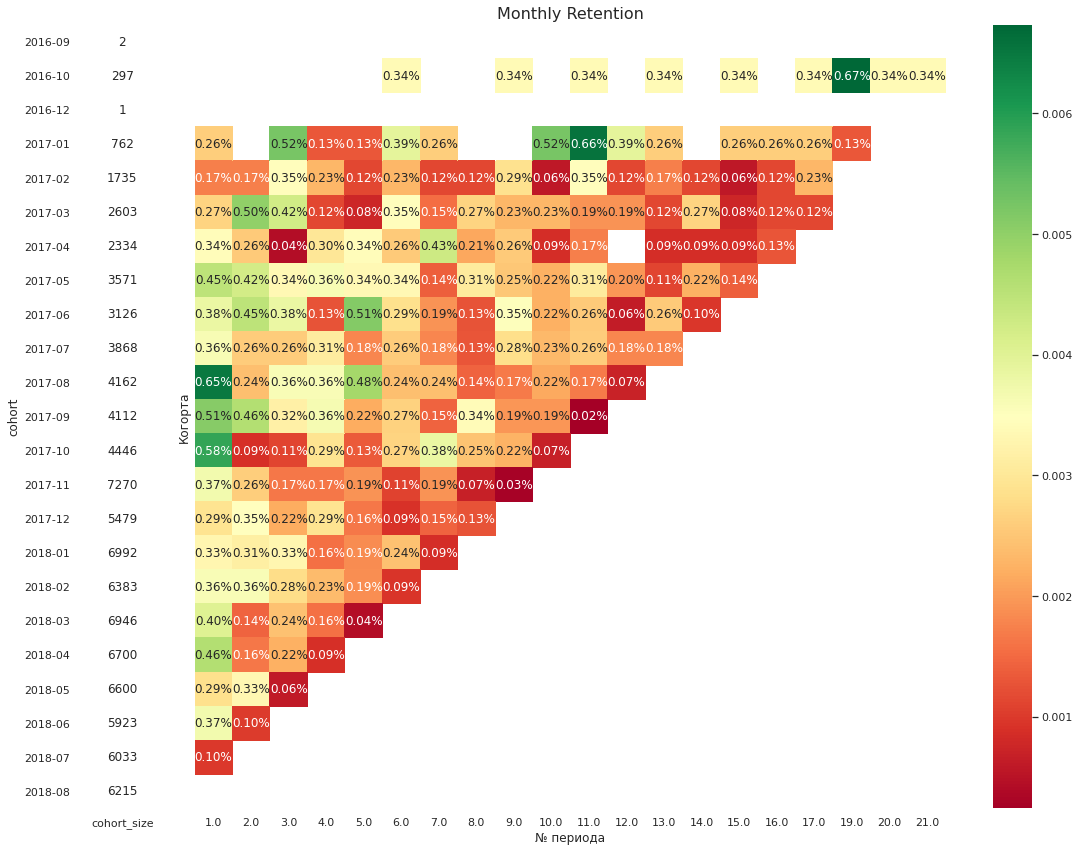

In [23]:
# Строим тепловую карту когортного анализа
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(16, 12), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

    # Тепловая карта для коэффициентов удержания
    sns.heatmap(retention_matrix_copy,
                mask=retention_matrix_copy.isnull(),
                annot=True,
                fmt='.2%',
                cmap='RdYlGn',
                ax=ax[1])
    ax[1].set_title('Monthly Retention', fontsize=16)
    ax[1].set(xlabel='№ периода', ylabel='Когорта')

    # Тепловая карта для размеров когорт
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df,
                annot=True,
                cbar=False,
                fmt='g',
                cmap=white_cmap,
                ax=ax[0])

    fig.tight_layout()
    plt.show()

In [24]:
# считаем медианный retention 1-го месяца = 0.36%
retention_matrix[1.0].median()

0.0036194415718717684

In [25]:
# определяем когорту с самым высоким retention = когорта 2017-01, retention = 0.52%
retention_matrix[3.0].sort_values(ascending=False)

cohort
2017-01    0.005249
2017-03    0.004226
2017-06    0.003839
2017-08    0.003604
2017-02    0.003458
2017-05    0.003360
2018-01    0.003289
2017-09    0.003161
2018-02    0.002820
2017-07    0.002585
2018-03    0.002447
2018-04    0.002239
2017-12    0.002190
2017-11    0.001651
2017-10    0.001125
2018-05    0.000606
2017-04    0.000428
2016-09         NaN
2016-10         NaN
2016-12         NaN
2018-06         NaN
2018-07         NaN
2018-08         NaN
Freq: M, Name: 3.0, dtype: float64

## 2. Существует ли product/market fit у маркетплейса?

#### Вывод:
текущий уровень retention указывает на отсутствие Product-Market Fit, пользователи не возвращаются в продукт после первого заказа

#### Рекомендации:
1. Провести пользовательские интервью 
2. Уточнить целевую аудиторию
3. Провести анализ и выяснить через все ли стадии заказ проходит без ошибок
4. Провести анализ качества и времени логистики 

In [26]:
# Преобразовываем retention matrix (по когортам) в агрегированный retention-профиль
# ntgthm каждый месяц отражает (взвешенный) retention по всем когортам вместе
weighted_retention = retention_matrix.multiply(cohort_size, axis=0)
overall_retention = weighted_retention.sum(axis=0) / cohort_size.sum()

In [27]:
overall_retention

period_number_month
0.0     1.000000
1.0     0.003464
2.0     0.002365
3.0     0.001988
4.0     0.001653
5.0     0.001402
6.0     0.001287
7.0     0.001015
8.0     0.000806
9.0     0.000795
10.0    0.000596
11.0    0.000607
12.0    0.000303
13.0    0.000314
14.0    0.000230
15.0    0.000136
16.0    0.000105
17.0    0.000105
19.0    0.000031
20.0    0.000010
21.0    0.000010
dtype: float64

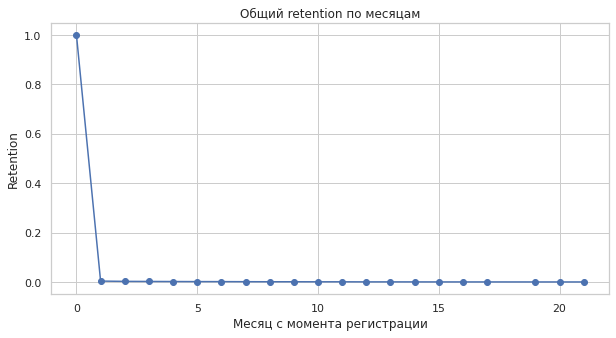

In [28]:
# изобразим retention на графике
plt.figure(figsize=(10, 5))
overall_retention.plot(marker='o')
plt.title("Общий retention по месяцам")
plt.xlabel("Месяц с момента регистрации")
plt.ylabel("Retention")
plt.grid(True)
plt.show()

## 3. Выбор и расчет 5 основных метрик, на которых стоит сконцентрироваться, чтобы максимизировать прибыль компании.

#### Выделяем следующие 5 метрик:
1. Monthly GMV(Gross Merchandise Value) - отражает общий объем продаж маркетплейса  
2. MAB (Monthly Active Buyers) - количество уникальных покупателей, совершивших хотя бы один заказ в каждый месяц
3. Activation rate - конверсия из регистрации в первый заказ
4. Retention rate - вовлеченность клиента в продолжение использования продукта | RPR (Repeat Purchase Rate) - доля пользователей совершивших хотя бы один повторный заказ
5. ARPPU - средняя сумма, потраченная одним покупателем за месяц  

#### 1. Monthly GMV (Gross Merchandise Value)

In [29]:
# собираем необходимые данные: id заказа, дата заказа, сумма заказа
GMV_data = olist_order_items.groupby('order_id', as_index = False).agg({'price': 'sum'})
GMV_data = GMV_data.merge(olist_orders, on='order_id', how='left')\
    .query('order_status == "delivered"')\
    .drop(['customer_id', 'order_status', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'], axis=1)

In [30]:
GMV_data = GMV_data.rename(columns = {'price': 'order_value', 'order_purchase_timestamp': 'order_date'})

In [31]:
GMV_data.head()

,order_id,order_value,order_date
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,2017-09-13 08:59:02
1,00018f77f2f0320c557190d7a144bdd3,239.90,2017-04-26 10:53:06
2,000229ec398224ef6ca0657da4fc703e,199.00,2018-01-14 14:33:31
3,00024acbcdf0a6daa1e931b038114c75,12.99,2018-08-08 10:00:35
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,2017-02-04 13:57:51


In [32]:
monthly_GMV = GMV_data.groupby(GMV_data['order_date'].dt.to_period('M'))['order_value'].sum()
monthly_GMV.index = monthly_GMV.index.to_timestamp()

In [33]:
monthly_GMV

order_date
2016-09-01       134.97
2016-10-01     40325.11
2016-12-01        10.90
2017-01-01    111798.36
2017-02-01    234223.40
2017-03-01    359198.85
2017-04-01    340669.68
2017-05-01    489338.25
2017-06-01    421923.37
2017-07-01    481604.52
2017-08-01    554699.70
2017-09-01    607399.67
2017-10-01    648247.65
2017-11-01    987765.37
2017-12-01    726033.19
2018-01-01    924645.00
2018-02-01    826437.13
2018-03-01    953356.25
2018-04-01    973534.09
2018-05-01    977544.69
2018-06-01    856077.86
2018-07-01    867953.46
2018-08-01    838576.64
Name: order_value, dtype: float64

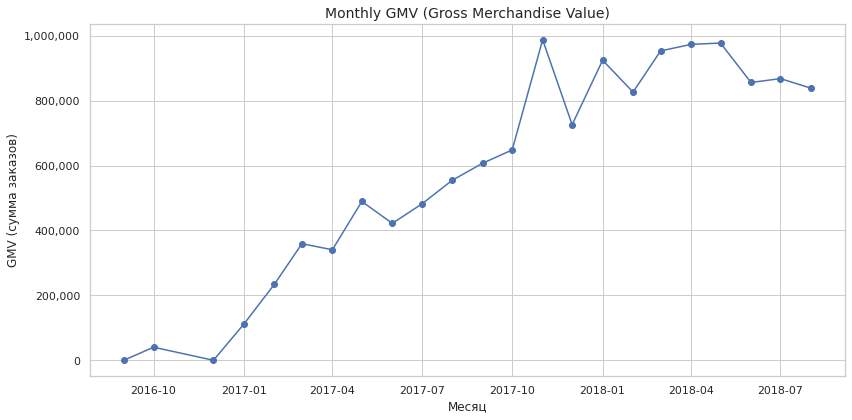

In [34]:
import matplotlib.ticker as mtick

plt.figure(figsize=(12, 6))
plt.plot(monthly_GMV.index, monthly_GMV.values, marker='o', linestyle='-')
plt.title('Monthly GMV (Gross Merchandise Value)', fontsize=14)
plt.xlabel('Месяц')
plt.ylabel('GMV (сумма заказов)', fontsize=12)

# Форматируем Y: тысячи через запятую, без десятичных
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

plt.grid(True)
plt.tight_layout()
plt.show()

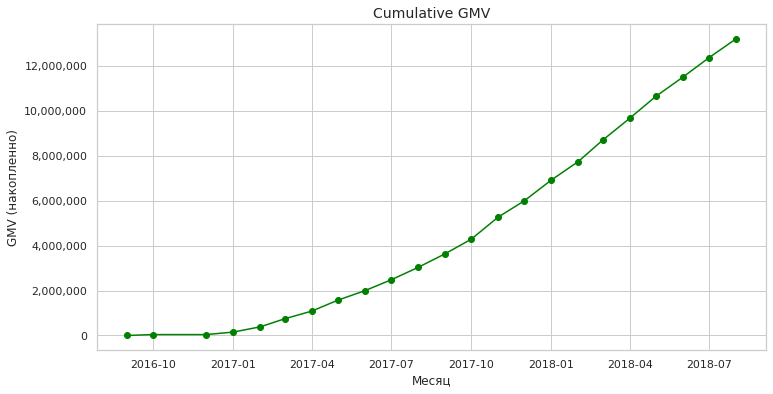

In [35]:
cumulative_GMV = monthly_GMV.cumsum()

plt.figure(figsize=(12, 6))
plt.plot(cumulative_GMV.index, cumulative_GMV.values, marker='o', color='green')
plt.title('Cumulative GMV', fontsize=14)
plt.xlabel('Месяц')
plt.ylabel('GMV (накопленно)')

# Форматируем Y: тысячи через запятую, без десятичных
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

plt.grid(True)
plt.show()

#### 2. MAB (Monthly Active Buyers)

In [36]:
# собираем необходимые данные: user_id, order_date, order_value

In [37]:
customers = olist_customers[['customer_id', 'customer_unique_id']]

In [38]:
MAB_data = olist_order_items.groupby('order_id', as_index=False).agg({'price': 'sum'})
MAB_data = MAB_data.merge(olist_orders, on='order_id', how='left')\
    .query('order_status == "delivered"')\
    .drop(['order_status', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'], axis=1)\
    .rename(columns = {'price': 'order_value', 'order_purchase_timestamp': 'order_date'})\
    .merge(customers, on='customer_id', how='left')\
    .drop(['customer_id'], axis=1)

In [39]:
MAB_data.head()

,order_id,order_value,order_date,customer_unique_id
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,2017-09-13 08:59:02,871766c5855e863f6eccc05f988b23cb
1,00018f77f2f0320c557190d7a144bdd3,239.90,2017-04-26 10:53:06,eb28e67c4c0b83846050ddfb8a35d051
2,000229ec398224ef6ca0657da4fc703e,199.00,2018-01-14 14:33:31,3818d81c6709e39d06b2738a8d3a2474
3,00024acbcdf0a6daa1e931b038114c75,12.99,2018-08-08 10:00:35,af861d436cfc08b2c2ddefd0ba074622
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,2017-02-04 13:57:51,64b576fb70d441e8f1b2d7d446e483c5


In [40]:
# Выделяем месяц покупки
MAB_data['order_month'] = MAB_data['order_date'].dt.to_period('M')

# Считаем уникальных покупателей по месяцам
monthly_active_buyers = MAB_data.groupby('order_month')['customer_unique_id'].nunique()

# Приводим индекс к timestamp 
monthly_active_buyers.index = monthly_active_buyers.index.to_timestamp()

In [41]:
monthly_active_buyers.head()

order_month
2016-09-01       1
2016-10-01     262
2016-12-01       1
2017-01-01     718
2017-02-01    1630
Name: customer_unique_id, dtype: int64

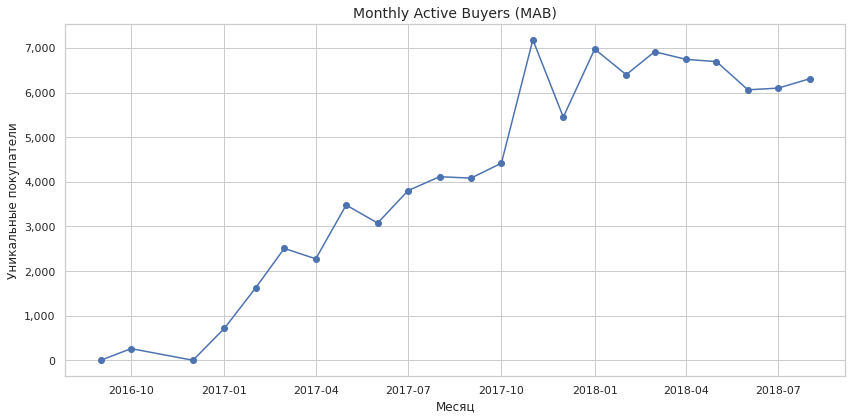

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_active_buyers.index, monthly_active_buyers.values, marker='o', linestyle='-')
plt.title('Monthly Active Buyers (MAB)', fontsize=14)
plt.xlabel('Месяц')
plt.ylabel('Уникальные покупатели', fontsize=12)

# Форматируем ось Y с разделителями тысяч
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

plt.grid(True)
plt.tight_layout()
plt.show()

#### 4.1. Retention
Общий retention мы считали на предыдущем степе (ниже дублируем график), поэтому также посчитаем и изобразим RPR

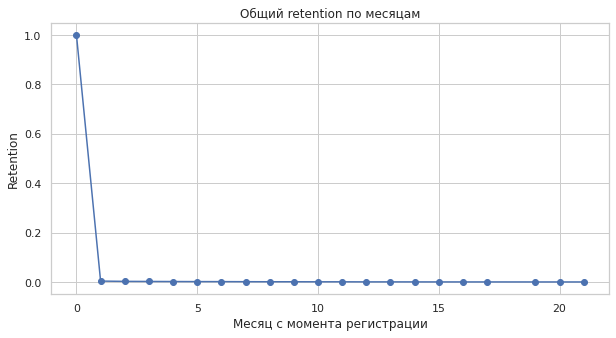

In [43]:
# retention на графике
plt.figure(figsize=(10, 5))
overall_retention.plot(marker='o')
plt.title("Общий retention по месяцам")
plt.xlabel("Месяц с момента регистрации")
plt.ylabel("Retention")
plt.grid(True)
plt.show()

#### 4.2. RPR (Repeat Purchase Rate)

In [44]:
# Возьмем таблицу, где у нас есть данные об уникальных пользователях и их заказах
orders_by_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


In [45]:
# Считаем количество уникальных доставленных заказов на каждого пользователя
orders_per_users = orders_by_customers.query('order_status == "delivered"')\
    .groupby('customer_unique_id')['order_id'].nunique()
# Рассчитываем количество пользователей с 2 и более заказами и делим их на всех пользователей 
repeat_bayers = orders_per_users[orders_per_users >= 2].count()
total_bayers = orders_per_users.count()

In [46]:
Repeat_Purchase_Rate = repeat_bayers / total_bayers 
print(f"Repeat Purchase Rate: {Repeat_Purchase_Rate:.2%}")

Repeat Purchase Rate: 3.00%


Изобразим RPR в динамике по месяцам

In [47]:
# Делаем всё то же самое только в рамках каждого месяца отдельно
# Для этого добавляем месяц покупки
orders_by_customers['order_month'] = orders_by_customers['order_purchase_timestamp'].dt.to_period('M')

# Рассчитываем количество заказов на пользователя в каждом месяце
orders_per_user_month = orders_by_customers.query('order_status == "delivered"')\
    .groupby(['order_month', 'customer_unique_id'])['order_id'].nunique()

# Рассчитываем количество пользователей с 2 и более заказами и делим их на всех пользователей
repeat_buyers_monthly = orders_per_user_month[orders_per_user_month >= 2].groupby('order_month').count()
total_buyers_monthly = orders_per_user_month.groupby('order_month').count()
repeat_purchase_rate_monthly = (repeat_buyers_monthly / total_buyers_monthly).fillna(0)

# Приводим индекс к Timestamp для графика
repeat_purchase_rate_monthly.index = repeat_purchase_rate_monthly.index.to_timestamp()

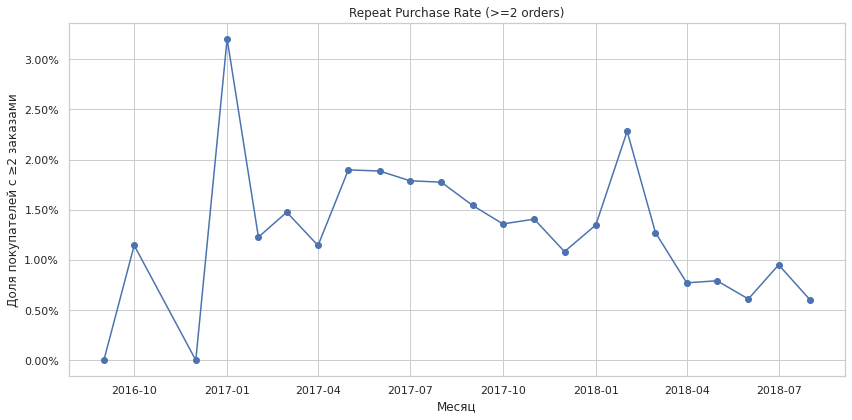

In [48]:
ig, ax = plt.subplots(figsize=(12, 6))
ax.plot(repeat_purchase_rate_monthly.index, repeat_purchase_rate_monthly.values, marker='o')
ax.set_title('Repeat Purchase Rate (>=2 orders)')
ax.set_xlabel('Месяц')
ax.set_ylabel('Доля покупателей с ≥2 заказами')

# Отображаем в процентах
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.grid(True)
plt.tight_layout()
plt.show()

#### 5. ARPPU - Средняя сумма, потраченная одним клиентом за месяц 
Расчет ARPPU = GMV / количество уникальных покупателей

In [49]:
total_bm = total_buyers_monthly.to_frame().reset_index()\
    .rename(columns={'order_month': 'month', 'order_id': 'user_counts'})
total_bm.head()

,month,user_counts
0,2016-09,1
1,2016-10,262
2,2016-12,1
3,2017-01,718
4,2017-02,1630


In [50]:
gmv = monthly_GMV.to_frame().reset_index()
gmv['month'] = gmv['order_date'].dt.to_period('M')
gmv.head()

,order_date,order_value,month
0,2016-09-01,134.97,2016-09
1,2016-10-01,40325.11,2016-10
2,2016-12-01,10.90,2016-12
3,2017-01-01,111798.36,2017-01
4,2017-02-01,234223.40,2017-02


In [51]:
arppu_df = gmv.merge(total_bm, on='month')
arppu_df['arppu'] = arppu_df['order_value'] / arppu_df['user_counts']
arppu_df.head()

,order_date,order_value,month,user_counts,arppu
0,2016-09-01,134.97,2016-09,1,134.970000
1,2016-10-01,40325.11,2016-10,262,153.912634
2,2016-12-01,10.90,2016-12,1,10.900000
3,2017-01-01,111798.36,2017-01,718,155.708022
4,2017-02-01,234223.40,2017-02,1630,143.695337


In [52]:
arppu = arppu_df[['month', 'arppu']]
arppu.head()

,month,arppu
0,2016-09,134.970000
1,2016-10,153.912634
2,2016-12,10.900000
3,2017-01,155.708022
4,2017-02,143.695337


In [53]:
series_arppu = pd.Series(data=arppu['arppu'].values, index=arppu['month'])
series_arppu = series_arppu.sort_index()

# Приводим индекс к Timestamp для графика
series_arppu.index = series_arppu.index.to_timestamp()

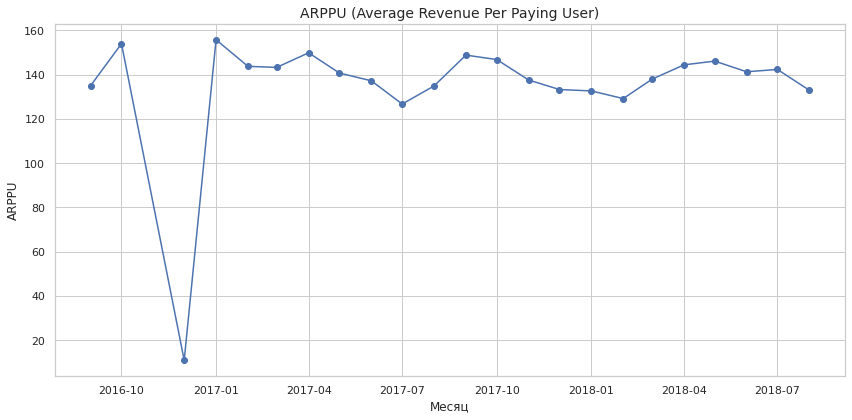

In [54]:
plt.figure(figsize=(12, 6))
plt.plot(series_arppu.index, series_arppu.values, marker='o', linestyle='-')
plt.title('ARPPU (Average Revenue Per Paying User)', fontsize=14)
plt.xlabel('Месяц')
plt.ylabel('ARPPU', fontsize=12)
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))  # денежный формат
plt.grid(True)
plt.tight_layout()
plt.show()

## 4. Выбор одной из 3 основных гипотез с помощью фреймворка ICE
#### У нас есть три сформулированные гипотезы:
1. Если исправим баг в системе процессинга заказов, то клиентам не придётся сталкиваться с проблемой отмены заказа, вследствие чего количество доставленных заказов увеличится. Считаем, что мы таким образом избавимся от всех отмен.
2. Если сократим время до отгрузки заказа, то клиенты перестанут получать свой заказ с запаздыванием, вследствие чего количество заказов увеличится за счёт повторных заказов.
3. Если создадим новый способ оплаты, который будет конвертировать клиентов в повторный заказ, то клиенты не будут испытывать трудности при оформлении заказа, вследствие чего количество заказов увеличится за счёт повторных заказов тех, кто раньше не делал повторный заказ.

#### Необходимо рассчитать Impact по кадой из них, значения Confidence и Ease заданы по условию:
1. Confidence = 8, Ease = 6;
2. Confidence = 10, Ease = 4;
3. Confidence = 5, Ease = 9;

#### Считаем impact для первой гипотезы

In [55]:
# По условию необходимо взять данные за июль 2017 года
olist_orders['month'] = olist_orders['order_purchase_timestamp'].dt.to_period('M')
olist_orders_impact = olist_orders.query('month >= "2017-06"')
olist_orders_impact.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018-07
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017-11
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018-02


In [56]:
# Считаем все униальные отмененные заказы
olist_orders_impact = olist_orders_impact.merge(customers, on='customer_id', how='left')
olist_orders_canceled = olist_orders_impact.query('order_status == "canceled"')
n_orders = olist_orders_canceled['order_id'].nunique()
impact = n_orders
print(f"Impact в количестве заказов: {impact}") 

Impact в количестве заказов: 499


In [57]:
# Для перевода получившего значения воспользуемся шкалой из условия задачи, где значения в диапазоне [351; 750] = 4

#### Считаем impact для второй гипотезы

In [58]:
# Считаем всех клиентов, получивших свой заказ с опозданием
olist_orders_impact['delay'] = olist_orders_impact.order_delivered_customer_date - olist_orders_impact.order_estimated_delivery_date
olist_orders_delay = olist_orders_impact.query('delay > @pd.Timedelta("1d")').dropna(subset=['delay'])
n_orders_delay = olist_orders_delay['order_id'].nunique()
impact_2 = n_orders_delay
print(f"Impact в количестве заказов: {impact_2}") 

Impact в количестве заказов: 6088


In [59]:
# Для перевода получившего значения воспользуемся шкалой из условия задачи, где значения в диапазоне [3151; 6350] = 7 

#### Считаем impact для третьей гипотезы

In [60]:
impact_3 = olist_orders_impact.query('order_status == "delivered" and delay < @pd.Timedelta("1d")')\
    .groupby('customer_unique_id').agg({'order_id': 'count'})\
    .query('order_id == 1')\
    .count()
print(f"Impact в количестве пользователей с 1 заказом: {impact_3}") 

Impact в количестве пользователей с 1 заказом: order_id    74975
dtype: int64


In [61]:
# Для перевода получившего значения воспользуемся шкалой из условия задачи, где значения в диапазоне [51151; 75350] = 10

#### Выбираем одну из трех гипотез, используя фреймворк ICE:
1. Impact = 4, Confidence = 8, Ease = 6; ICE = 192;
2. Impact = 7, Confidence = 10, Ease = 4; ICE = 280;
3. Impact = 10, Confidence = 5, Ease = 9; ICE = 450;

## Вывод: выбираем третью гипотезу

## 5. Метрики, на которые выбранная гипотеза должна повлиять.

#### Гипотеза:
Если создадим новый способ оплаты, который будет конвертировать клиентов в повторный заказ, то клиенты не будут испытывать трудности при оформлении заказа, вследствие чего количество заказов увеличится за счёт повторных заказов тех, кто раньше не делал повторный заказ

#### Целевые метрики:
1. Conversion to Repeat - конверсия из первой покупки во вторую: показывает первый шаг удержания

#### Прокси метрики:
1. Conversion rate из оформления в оплату: покажет успешно оплаченные заказы
2. Time to complete payment - время между оформлением заказа и оплатой: должно уменьшаться

#### guardrail метрики:
1. Order success rate - доля доставленных заказов: не должна падать 

## 6. Результаты

#### Проблемы продукта: 
Очень низкий retentoin (удержание пользователей) на уровне 0.36%, а также низкая доля покупателей, совершивших второй заказ 3%

#### Общие выводы на основе данных:
1. Пользователи уходят из продукта, не совершая второй заказ
2. Более 6000 клиентов получили свой заказ с опозданием
3. Product/market fit не достигнут - продукт масштабировать нельзя 

#### Рекомендации:
1. Добавить новые способы оплаты
2. Наладить процессы логистики
3. Поисследовать все стадии, которые проходит заказ; выявить те, на которых возникает наибольшее количество проблем  